In [1]:

import random

import matplotlib.pyplot as plt
import numpy as np

import tensorflow
import keras
from tensorflow.keras.layers import Dense, Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Activation, Conv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import  fashion_mnist


# Cargar MNist

Nos quedamos solo las camisetas que son donde es 0 

(6000, 28, 28)

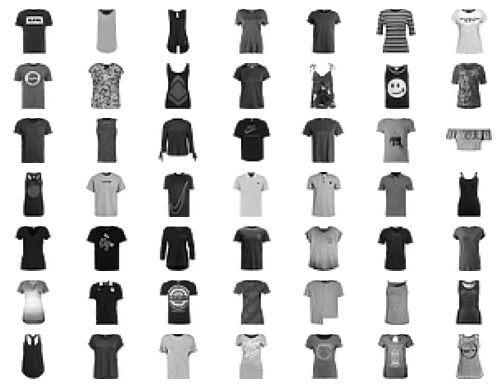

In [2]:
def cargar_imagenes():
    (Xtrain, Ytrain), (_, _) = fashion_mnist.load_data()

    # Nos quedamos con las camiseta
    indice = np.where(Ytrain == 0)
    indice = indice[0]
    Xtrain = Xtrain[indice, :,:]
    # Normalizamos los datos
    X = Xtrain.astype('float32') / 255.0
    return X

dataset = cargar_imagenes()

for i in range(49):
  plt.subplot(7, 7, 1 + i)
  plt.axis('off')
  plt.imshow(dataset[i], cmap="binary")

dataset.shape

# Creación del discriminador

In [3]:


discriminador = Sequential()

# Padding same permite que si es multiplo de 3 no se pierdan valores
discriminador.add(Conv2D(8,kernel_size=3,padding="same",
                         input_shape=(dataset.shape[1],dataset.shape[2],1),activation="relu"))

discriminador.add(MaxPool2D((2,2)))

discriminador.add(Conv2D(32,kernel_size=3,padding="same",activation="relu"))

discriminador.add(MaxPool2D((2,2)))

discriminador.add(Conv2D(64,kernel_size=3,padding="same",activation="relu"))

discriminador.add(MaxPool2D((2,2)))

discriminador.add(Flatten())

discriminador.add(Dense(32,activation="relu"))


discriminador.add(Dense(1,activation="sigmoid"))

discriminador.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        2336      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 64)          0

In [4]:
# Tiene que haber poco LR para poder entrenar los modelos con calma
discriminador.compile(loss="binary_crossentropy", optimizer = Adam(learning_rate=0.0001), metrics=["accuracy"])

In [5]:
discriminador.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        2336      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 64)          0

# Creación del generador

In [6]:
generador = Sequential()

# Vamos en incremento para intentar simular el Flatten del modelo Discriminador
generador.add(Dense(32,input_shape=(1,),activation="relu"))

# No tiene porqué pero va beneficiar la cantidad de neuronas = al discriminador
generador.add(Dense(576,activation="relu"))

# La capa de MaxPooling2D antes del Flatten para darle ya un Shape
generador.add(Reshape((3,3,64)))

# Lo que hace es que vaya a saltos de 2 como iba la capa de MaxPooling2D duplicando el tamaño x2
# Con Padding = "valid" tendría el mismo (None, 7, 7, 32) en la última capa que el Discriminador
# Ya que podemos gestionar el valor de diferencia con +1 o -1 de tamaño de imagen
generador.add(Conv2DTranspose(64,kernel_size=3, strides=2,padding="valid",activation="relu"))

# Añadimos una normalización del tipo BatchNormalization, cada Bach hace un repaso y los normaliza
generador.add(BatchNormalization())

# Borra la mitad de las neuronas de vez en cuando
generador.add(Dropout(0.5))

# Ahora tenemos que pasar de 7 a 14 con un 16 de Neuronas
generador.add(Conv2DTranspose(32,kernel_size=3, strides=2,padding="same",activation="relu"))

# Añadimos una normalización del tipo BatchNormalization, cada Bach hace un repaso y los normaliza
generador.add(BatchNormalization())

# Borra la mitad de las neuronas de vez en cuando
generador.add(Dropout(0.5))

# Ahora tenemos que pasar de 14 a 28 con 8 de Neuronas
generador.add(Conv2DTranspose(8,kernel_size=3, strides=2,padding="same",activation="relu"))

# Añadimos una normalización del tipo BatchNormalization, cada Bach hace un repaso y los normaliza
generador.add(BatchNormalization())

# Borra la mitad de las neuronas de vez en cuando
generador.add(Dropout(0.5))

# Ahora una capa con 1 y sin modificar el tamaño con strides=1 y que acabe entre 0 y 1 con sigmoid
generador.add(Conv2DTranspose(1,kernel_size=3,strides=1,padding="same",activation="sigmoid"))

generador.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                64        
                                                                 
 dense_3 (Dense)             (None, 576)               19008     
                                                                 
 reshape (Reshape)           (None, 3, 3, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 64)          36928     
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 7, 7, 64)          256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)         

In [7]:
gan = Sequential()
gan.add(generador)
gan.add(discriminador)
gan.compile(loss="binary_crossentropy", optimizer = Adam(learning_rate=0.0001), metrics=["accuracy"])


In [8]:
def get_datos_true(nmuestras):
    """Devuelve imagenes verdaderas del DataSet

    Args:
        muestras (pd.DataFrame): DataFrame de Pandas

    Returns:
        List: Devuelve el X e Y del DataSet 
    """
    v = np.random.randint(0,dataset.shape[0],nmuestras)
    X = dataset[v]
    y = np.ones((nmuestras,1))
    return X,y

def get_datos_fake(nmuestras):
    """Genera datos falsos con el generador

    Args:
        nmuestras (int): Número de muestras

    Returns:
        List: Devuelve X e Y de un falso DataSet predicho
    """
    input = np.random.rand(nmuestras)
    X = generador.predict(input)
    y = np.zeros((nmuestras,1))
    return X,y

def entrenamiento(epochs=1, batch_size=128):
    """Entrena el modelo de Generador y Detector

    Args:
        epochs (int, optional): Nº de Epochs. Defaults to 1.
        batch_size (int, optional): Tamaño de los saltos. Defaults to 128.
    """
    max_len = dataset.shape[0]
    nbatchs = int(max_len / batch_size)
    acc_r,acc_f,acc_g=[],[],[]
    for epoch in range(epochs):
        print("Epoch : ", epoch)
        for batch in range(nbatchs):

            #region Discriminador

            discriminador.trainable = True
            X_real,y_real = get_datos_true(batch_size//2)
            # Permite entrenar a cachos el discriminador
            loss_real, acc_real = discriminador.train_on_batch(X_real,y_real)

            X_fake,y_fake = get_datos_fake(batch_size//2)
            # Permite entrenar a cachos el discriminador
            loss_fake, acc_fake = discriminador.train_on_batch(X_fake,y_fake)

            discriminador.trainable = False

            #endregion

            #region Generador
            X_gan = np.random.randn(batch_size).reshape(batch_size,1)

            # Tenemos que intentar engañarlo, por lo que ponemos por la salida unos ya que significaría que son correctos
            # Hasta que el otro diga lo contrario
            y_gan = np.ones((batch_size,1))

            loss_gan, acc_gan = gan.train_on_batch(X_gan,y_gan)
            #endregion

            print(f"Epoch: {epoch} - Batch: {batch}")
            print(f"loss_real: {loss_real} - loss_fake: {loss_fake} - loss_gan: {loss_gan}")
            print(f"acc_real: {acc_real} - acc_fake: {acc_fake} - acc_gan: {acc_gan}")
            acc_r.append(acc_real)
            acc_f.append(acc_fake)
            acc_g.append(acc_gan)
    return acc_r,acc_f,acc_g

In [9]:
values=entrenamiento(epochs=50)

Epoch :  0
2/2 [==============================] - 0s 0s/step
Epoch: 0 - Batch: 0
loss_real: 0.7123667001724243 - loss_fake: 0.6818949580192566 - loss_gan: 0.7127236723899841
acc_real: 0.0 - acc_fake: 1.0 - acc_gan: 0.015625
2/2 [==============================] - 0s 16ms/step
Epoch: 0 - Batch: 1
loss_real: 0.6990309953689575 - loss_fake: 0.6851196885108948 - loss_gan: 0.6965317130088806
acc_real: 0.171875 - acc_fake: 1.0 - acc_gan: 0.2734375
2/2 [==============================] - 0s 16ms/step
Epoch: 0 - Batch: 2
loss_real: 0.6902042627334595 - loss_fake: 0.6874934434890747 - loss_gan: 0.6836322546005249
acc_real: 0.703125 - acc_fake: 1.0 - acc_gan: 0.9375
2/2 [==============================] - 0s 0s/step
Epoch: 0 - Batch: 3
loss_real: 0.6817971467971802 - loss_fake: 0.690351665019989 - loss_gan: 0.6736879944801331
acc_real: 0.921875 - acc_fake: 1.0 - acc_gan: 1.0
2/2 [==============================] - 0s 0s/step
Epoch: 0 - Batch: 4
loss_real: 0.6749916076660156 - loss_fake: 0.6926749944

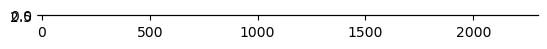

In [10]:
plt.imshow(values)

2/2 [==============================] - 0s 0s/step


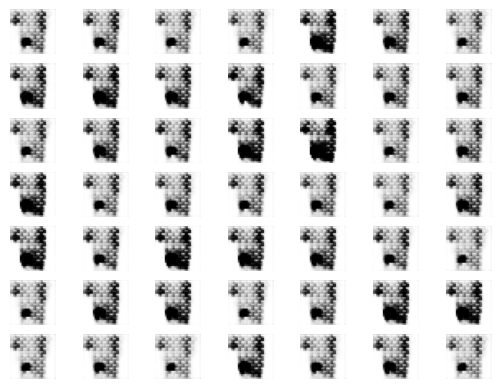

In [11]:
# Hay que intentar estabilizar la red

X_pru = np.random.randn(49)
generadas = generador.predict(X_pru)
for i in range(49):
  plt.subplot(7,7,i+1)
  plt.axis('off')
  plt.imshow(generadas[i], cmap="binary")
plt.show()